<a id="0"></a>

<center><img src='https://static.wixstatic.com/media/24bff7_74439e8fe4c74187af5bcf365cf9eeb2~mv2.png/v1/fill/w_1000,h_657,al_c,q_90,usm_0.66_1.00_0.01/24bff7_74439e8fe4c74187af5bcf365cf9eeb2~mv2.png' 
     height=400px width=1200px /></center>

<p style="text-align: center;"><b><span style="color: #28838a; font-family: 'verdana'; font-size: 25px;">📖 Introduction </span></b></p>

<div style="background-color:#f0f4f5; padding: 5px;">

<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
<b><span style='color:#fa762f'> </span><span style='color:#28838a'> What is Time Series? </span></b> 

Time series is a unique type of problem in machine learning where the time component plays a critical role in the model predictions. As observations are dependent on adjacent observations, this violates the assumption that observations are independent to each other followed by most conventional machine learning models.<br><br>
    
Common use cases of time series analysis are forecasting future numeric values, e.g. stock pricing, revenue, temperature, which falls under the category of regression models. However, time series models can also be applied in classification problems, for instance, pattern recognition in brain wave monitoring, or failure identification in the production process are common applications of time series classifiers.<br><br>

In this notebook, we will lean concepts of the time series model - AR, MA, ARMA, ARIMA, and SARIMA for regression problems where we forecast numeric values. Time series regression differentiates from other regression models, because of its assumption that data correlated over time and the outcomes from previous periods can be used for predicting the outcomes in the subsequent periods.<br><br>
    
The below dataset is having the monthly Sales data for the days Trucks of a certain company are being sold for the year 2022. The objective of this problem is to build a ARIMA/SARIMA forecasting model to forecast next 3 years of future sales<br>
</div>

<b><span style='color:#fa762f; font-size: 22px;'></span><span style='color:#28838a; font-size: 20px;'> Import Libraries & Load Dataset </span></b>


In [1]:
import sys
import itertools
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

import warnings
warnings.filterwarnings("ignore")

In [2]:
data = pd.read_csv("C:/Users/91938/Downloads/DataSets/Truck_sales.csv")
data.head()

,Month-Year,Number_Trucks_Sold
0,03-Jan,155
1,03-Feb,173
2,03-Mar,204
3,03-Apr,219
4,03-May,223


#### Let's split the data as per frequency

In [3]:
dates = pd.date_range(start='2003-01-01', freq='MS', periods=len(data))

In [4]:
#Creating new columns with Month & date
import calendar
data['Month'] = dates.month
data['Month'] = data['Month'].apply(lambda x: calendar.month_abbr[x]) #spltting into english month names
data['Year'] = dates.year

In [5]:
#Dropping the original Month-Year column
data.drop(['Month-Year'], axis=1, inplace=True)
data.rename(columns={'Number_Trucks_Sold':'Truck-Sales'}, inplace=True) #renaming Number_Trucks_Sold column
data = data[['Month', 'Year', 'Truck-Sales']]

In [6]:
data.set_index(dates, inplace=True)
data.head()

,Month,Year,Truck-Sales
2003-01-01,Jan,2003,155
2003-02-01,Feb,2003,173
2003-03-01,Mar,2003,204
2003-04-01,Apr,2003,219
2003-05-01,May,2003,223


Text(0, 0.5, 'Truck Sales')

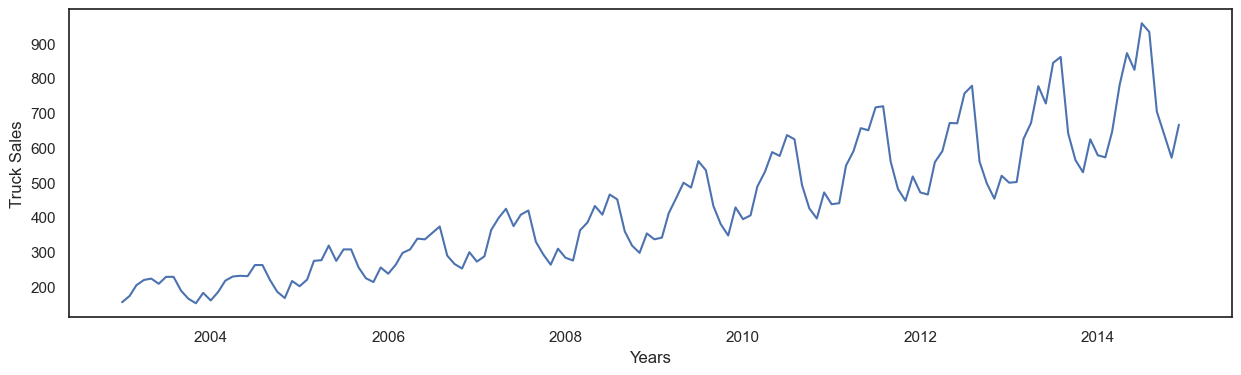

In [7]:
sales_ts = data['Truck-Sales']
sns.set(style="white", rc={'figure.figsize': (15, 4)})
plt.figure(figsize=(15, 4))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Truck Sales')

<p style="font-size:20px; font-family:verdana; line-height: 1.7em">We observe both trend and multiplicative seasonaliy from the plot shown above</p><br>

<a id="1"></a>
<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>

<p><b><span style="color:#28838a; font-family: 'verdana'; font-size:20px;">Concept of Stationary </span></b></p>

<div style="background-color:#f0f4f5; padding: 10px;">
 
<ul style="font-size:20px; font-family:verdana; line-height: 1.5em">
    
- A Time Series is considered to be stationary <b>when statistical properties such as the variance and (auto) correlation are constant over time.</b><br>
- Stationary Time Series allows us to think of the statistical properties of the time series as not changing in time, which enables us to build appropriate statistical models for forecasting based on past data.<br>
    
- Stationarity means that the <b>autocorrelation of lag ‘k’ depends on k, but not on time t.</b><br>
        
    - <font color='blue'> Let $𝑋_𝑡$  denote the time series at time t.<br>
    - Autocorrelation of lag k is the correlation between $𝑋_{𝑡}$  and $𝑋_{(𝑡−𝑘)}$</font><br><br>

<p><b><span style="color:#28838a; font-family: 'verdana'; font-size:20px;">How to check for Stationarity? </span></b></p>
   
<b><font color='blue'>Dickey-Fuller Test</font></b> - Dicky Fuller Test on the timeseries is run to check for stationarity of data.<br>
- Null Hypothesis $H_{0}$: Time Series is non-stationary.<br>
- Alternate Hypothesis $𝑯_{𝒂}$: Time Series is stationary.<br>

So Ideally if p-value < 0.05 then null hypothesis: TS is non-stationary is rejected else the TS is non-stationary is failed to be rejected.</p>
    </div>

In [8]:
dftest = adfuller(sales_ts) #python implementation of dicky fuller test
dftest

(1.1158932574252705,
 0.9953500083802602,
 14,
 129,
 {'1%': -3.482087964046026,
  '5%': -2.8842185101614626,
  '10%': -2.578864381347275},
 1107.5217075915425)

In [9]:
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is 1.116
DF test p-value is 0.9954


<p style="font-size:16px; font-family:verdana; line-height: 1.7em"> <b>The p-value 0.99 is very large, and not smaller than 0.05 and thus is not a stationary series</b></p>

<p><b><span style="color:#28838a; font-family: 'verdana'; font-size:20px;"> Bivariate Analysis</span></b></p>

<div style="background-color:#f0f4f5; padding: 10px;">
<ul style="font-size:20px; font-family:verdana; line-height: 1.5em">

Performing the decomposition of data if there is an existence of seasonality and split the data accordingly.<br>

Observe how number of Trucks sold vary on a month on month basis. A stacked plot for every year will give us a clear pattern of any seasonality over the many years and those changes will be clearly reflected in the plots.
    </div>

In [10]:
monthly_sales_data = pd.pivot_table(data, values = "Truck-Sales", columns = "Year", index = "Month")
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Apr,219.0,229.0,276.0,307.0,398.0,385.0,455.0,530.0,590.0,590.0,671.0,781.0
Aug,228.0,262.0,307.0,373.0,419.0,451.0,535.0,624.0,719.0,778.0,861.0,933.0
Dec,182.0,216.0,255.0,299.0,309.0,353.0,428.0,471.0,517.0,519.0,624.0,666.0
Feb,173.0,185.0,220.0,263.0,287.0,275.0,341.0,405.0,440.0,465.0,501.0,572.0
Jan,155.0,160.0,201.0,237.0,272.0,283.0,336.0,394.0,437.0,471.0,499.0,578.0
Jul,228.0,262.0,307.0,354.0,407.0,465.0,561.0,636.0,716.0,756.0,844.0,958.0
Jun,208.0,230.0,274.0,336.0,374.0,407.0,485.0,576.0,650.0,670.0,727.0,824.0
Mar,204.0,217.0,274.0,297.0,363.0,362.0,411.0,488.0,548.0,558.0,625.0,646.0
May,223.0,231.0,318.0,338.0,424.0,432.0,499.0,587.0,656.0,671.0,777.0,872.0


In [11]:
#Reindexing
monthly_sales_data = monthly_sales_data.reindex(index = ['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
monthly_sales_data

Year,2003,2004,2005,2006,2007,2008,2009,2010,2011,2012,2013,2014
Month,,,,,,,,,,,,
Jan,155.0,160.0,201.0,237.0,272.0,283.0,336.0,394.0,437.0,471.0,499.0,578.0
Feb,173.0,185.0,220.0,263.0,287.0,275.0,341.0,405.0,440.0,465.0,501.0,572.0
Mar,204.0,217.0,274.0,297.0,363.0,362.0,411.0,488.0,548.0,558.0,625.0,646.0
Apr,219.0,229.0,276.0,307.0,398.0,385.0,455.0,530.0,590.0,590.0,671.0,781.0
May,223.0,231.0,318.0,338.0,424.0,432.0,499.0,587.0,656.0,671.0,777.0,872.0
Jun,208.0,230.0,274.0,336.0,374.0,407.0,485.0,576.0,650.0,670.0,727.0,824.0
Jul,228.0,262.0,307.0,354.0,407.0,465.0,561.0,636.0,716.0,756.0,844.0,958.0
Aug,228.0,262.0,307.0,373.0,419.0,451.0,535.0,624.0,719.0,778.0,861.0,933.0
Sep,188.0,219.0,255.0,289.0,329.0,359.0,432.0,492.0,560.0,560.0,641.0,704.0


<p style="font-size:16px; font-family:verdana; line-height: 1.7em"> To represent the distribution of the data, if there is an existence of seasonality in a visualisation plot and provide inferences accordingly.</p>

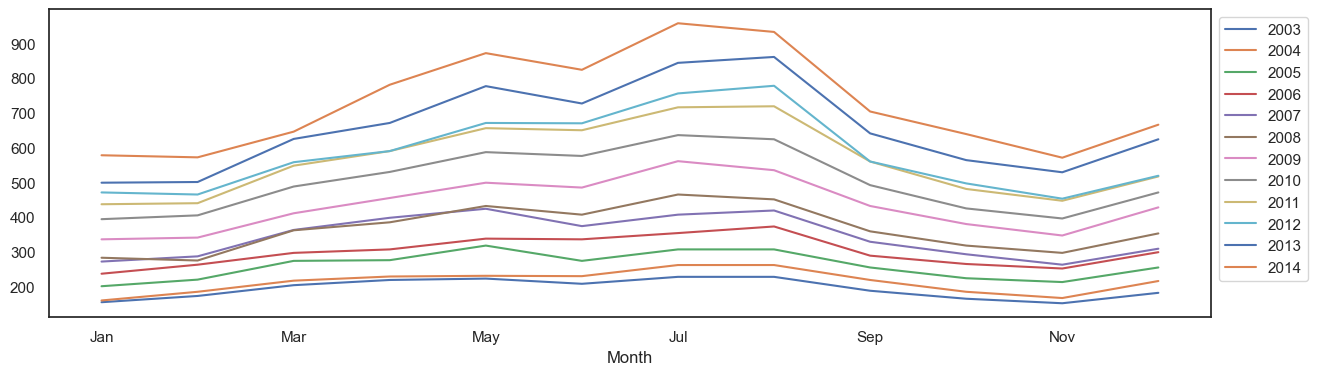

In [12]:
sns.set(style="white", rc={'figure.figsize': (15, 4)})
ax = monthly_sales_data.plot()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_facecolor('white')
plt.show()

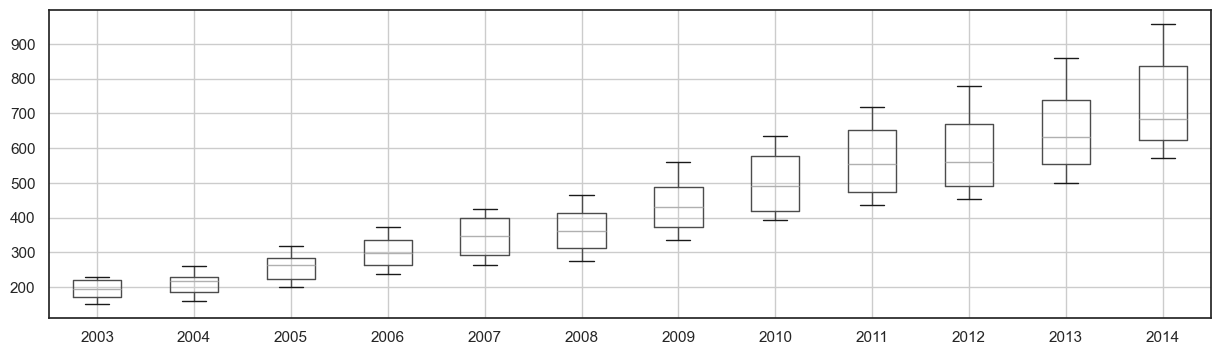

In [13]:
sns.set(style="white", rc={'figure.figsize': (15, 4)})
monthly_sales_data.boxplot()
plt.show()

In [14]:
yearly_sales_data = pd.pivot_table(data, values = "Truck-Sales", columns = "Month", index = "Year")
yearly_sales_data = yearly_sales_data[['Jan','Feb','Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']]
yearly_sales_data

Month,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep,Oct,Nov,Dec
Year,,,,,,,,,,,,
2003,155.0,173.0,204.0,219.0,223.0,208.0,228.0,228.0,188.0,165.0,152.0,182.0
2004,160.0,185.0,217.0,229.0,231.0,230.0,262.0,262.0,219.0,185.0,167.0,216.0
2005,201.0,220.0,274.0,276.0,318.0,274.0,307.0,307.0,255.0,224.0,213.0,255.0
2006,237.0,263.0,297.0,307.0,338.0,336.0,354.0,373.0,289.0,265.0,252.0,299.0
2007,272.0,287.0,363.0,398.0,424.0,374.0,407.0,419.0,329.0,293.0,263.0,309.0
2008,283.0,275.0,362.0,385.0,432.0,407.0,465.0,451.0,359.0,318.0,297.0,353.0
2009,336.0,341.0,411.0,455.0,499.0,485.0,561.0,535.0,432.0,380.0,347.0,428.0
2010,394.0,405.0,488.0,530.0,587.0,576.0,636.0,624.0,492.0,425.0,396.0,471.0
2011,437.0,440.0,548.0,590.0,656.0,650.0,716.0,719.0,560.0,481.0,447.0,517.0


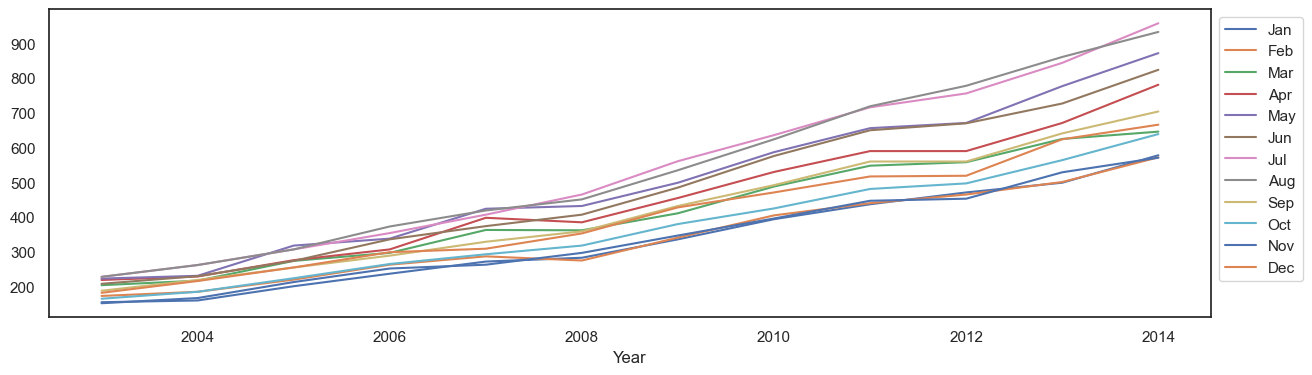

In [15]:
sns.set(style="white", rc={'figure.figsize': (15, 4)})
ax = yearly_sales_data.plot()
ax.legend(loc='upper left', bbox_to_anchor=(1, 1))
ax.set_facecolor('white')
plt.show()

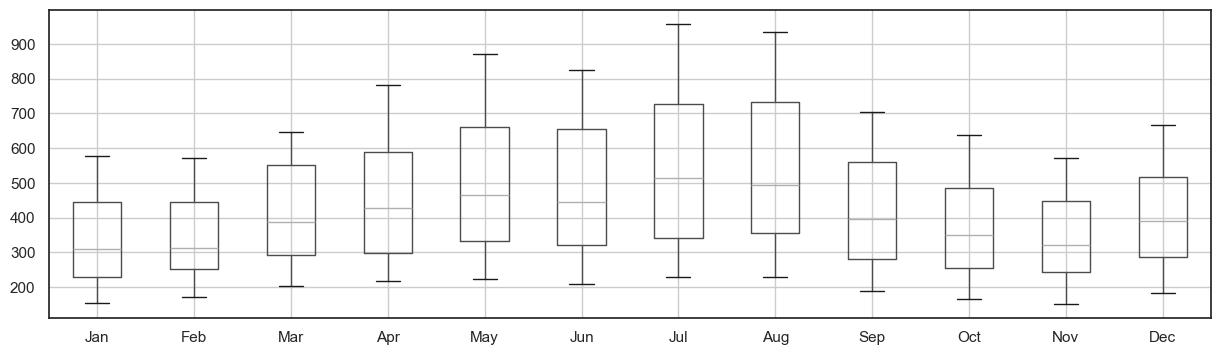

In [16]:
sns.set(style="white", rc={'figure.figsize': (15, 4)})
yearly_sales_data.boxplot()
plt.show()

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
<p><b><span style="color:#28838a; font-family: 'verdana'; font-size:20px;"> Inferences</span></b></p>


- The Truck sales have been increasing every year.<br>
- July/August are the peak months for sales<br>
- Variance & Mean values in the above 2 months are also higher than any of the other months.<br>
- 12 months seasonal cycle is present as mean of each month year on year starts with an increasing trend in the beginning of the year and drops down towards the end of the year.<br>
    </div>

<b><span style='color:#fa762f; font-size: 18px;'>  </span><span style='color:#28838a; font-size: 20px;'> Time Series Decomposition </span></b>


In [17]:
decomposition = sm.tsa.seasonal_decompose(sales_ts, model='multiplicative')

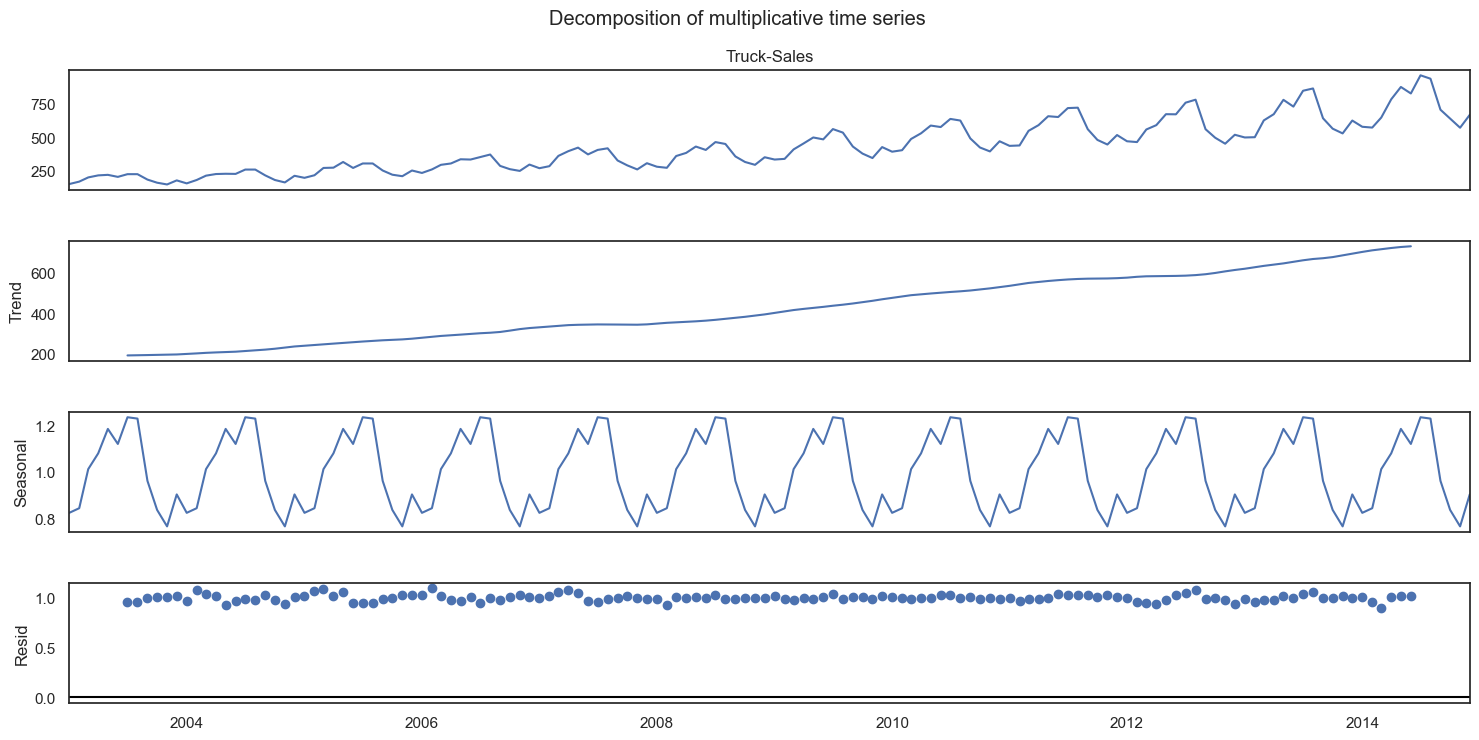

In [18]:
fig = decomposition.plot()
fig.set_figwidth(15)
fig.set_figheight(8)
fig.suptitle('Decomposition of multiplicative time series')
plt.show()

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
<b><span style='color:#28838a; font-size: 18px;'> Key observations </span></b>

1) Trend: 12-months MA is a fairly straight line indicating a linear trend.<br>

2) Seasonality: seasonality of 12 months is clearly visible<br>

3) Irregular Remainder (random): The multiplicative model works as there are no patterns in the residuals
    </div>

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
<b><span style='color:#28838a; font-size: 18px;'> How to Make a Time Series Stationary ? </span></b>

 - Differencing 'd'<br>
- Differencing 'd' is done on a non-stationary time series data one or more times to convert it into stationary.<br>


- <b>(d=1) 1st order differencing is done where the difference between the current and previous (1 lag before) series is taken and then checked for stationarity using the ADF(Augmented Dicky Fueller) test. If differenced time series is stationary, we proceed with AR modeling. Else we do (d=2) 2nd order differencing, and this process repeats till we get a stationary time series</b><br>

    - <font color='blue'> 1st  order differencing equation is : $𝒚_{𝒕} = 𝒚_{𝒕} − 𝒚_{𝒕-1}$<br>
    - 2nd order differencing equation is : $𝒚_{𝒕} = (𝒚_{𝒕} − 𝒚_{𝒕-1}) − (𝒚_{𝒕-1} -y_{t-2})$		and so on…</font><br>


- The variance of a time series may also not be the same over time.   To remove this kind of non-stationarity, we can transform     the data. <b>If the variance is increasing over time, then a log transformation can stabilize the variance.</b>
</div>

<b><span style='color:#fa762f; font-size: 18px;'>  </span><span style='color:#28838a; font-size: 20px;'> Non differenced full data Time series </span></b>

Text(0, 0.5, 'Truck Sales')

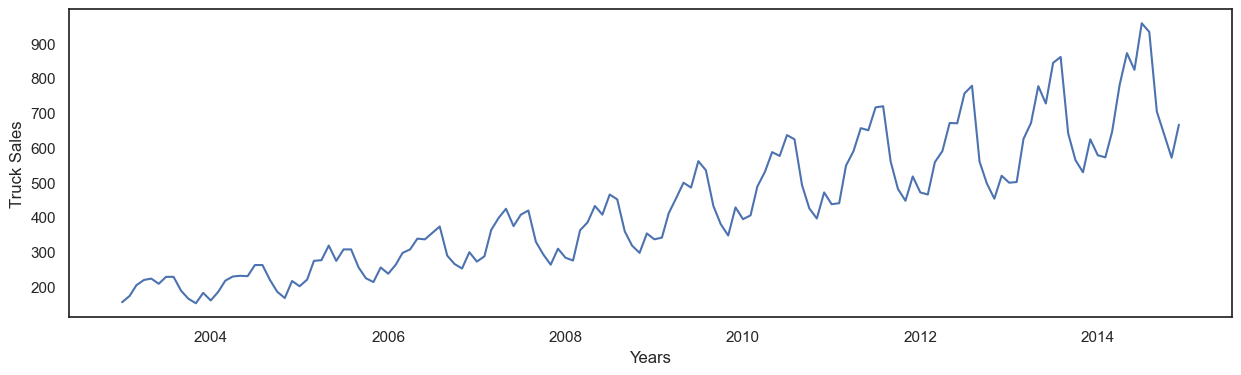

In [19]:
plt.figure(figsize=(15, 4))
plt.plot(sales_ts)
plt.xlabel('Years')
plt.ylabel('Truck Sales')

<b><span style='color:#fa762f; font-size: 18px;'>  </span><span style='color:#28838a; font-size: 20px;'> Performing differencing ( d=1 ) as the data is non-stationary </span></b>

Text(0, 0.5, 'Truck Sales')

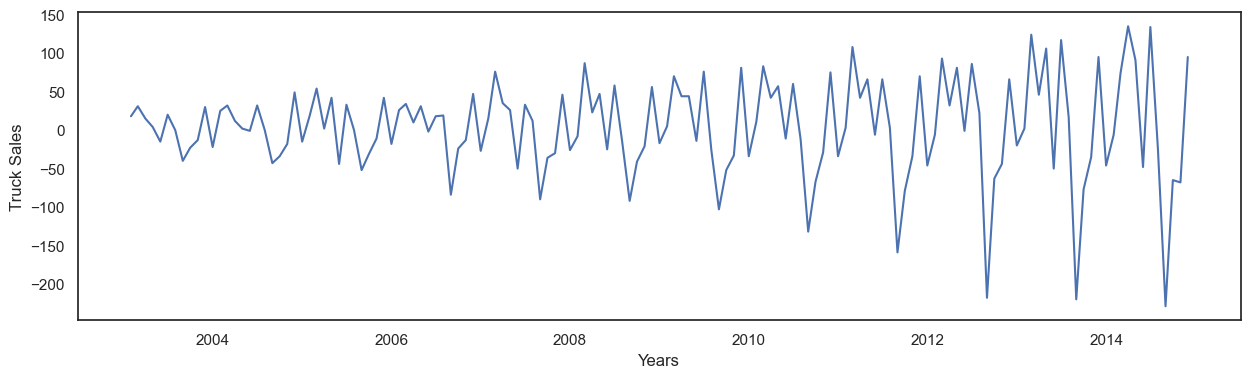

In [20]:
plt.figure(figsize=(15, 4))
plt.plot(sales_ts.diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Truck Sales')

Text(0, 0.5, 'Truck Sales')

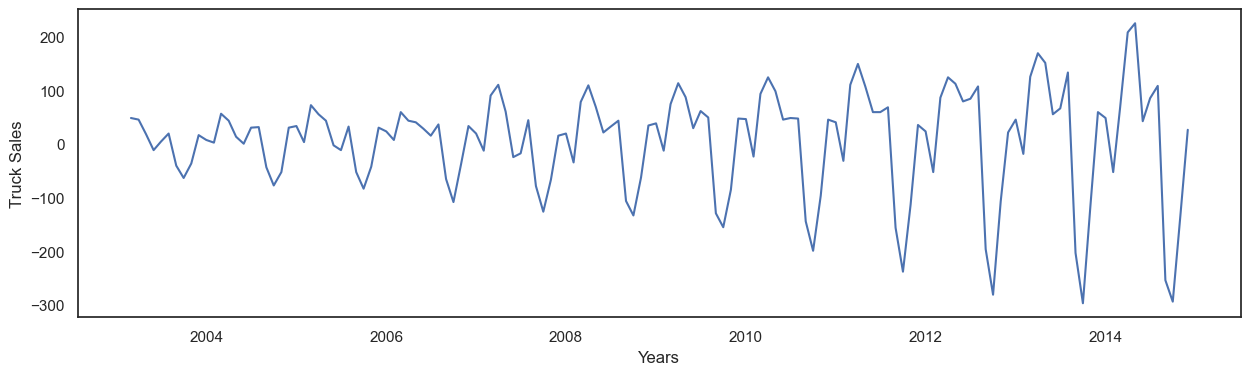

In [21]:
#Try for d=2
plt.figure(figsize=(15, 4))
plt.plot(sales_ts.diff(periods=2))
plt.xlabel('Years')
plt.ylabel('Truck Sales')

<p style="font-size:16px; font-family:verdana; line-height: 1.7em"> We observe seasonality even after differencing. Meaning the variance in the data seemss to be increasing.<br>This suggests a log transformation of the data </p>


Text(0, 0.5, 'Log (Truck Sales)')

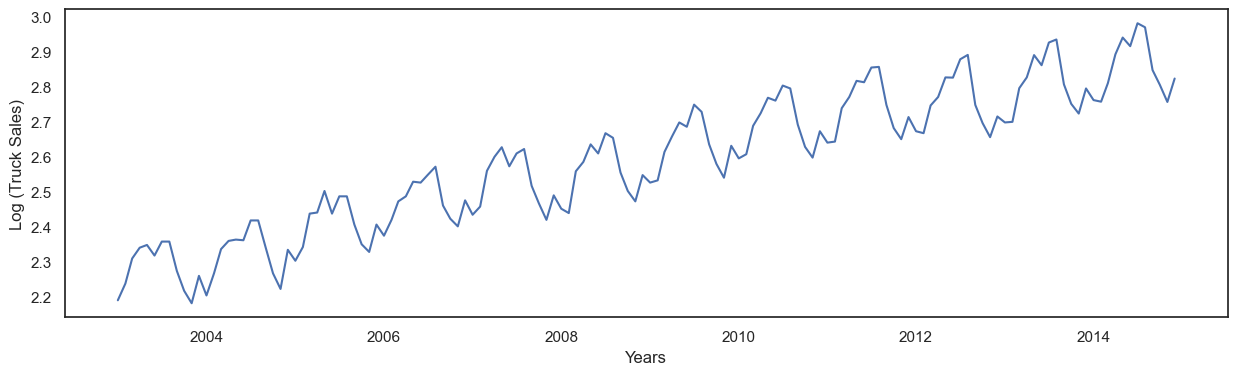

In [22]:
plt.figure(figsize=(15, 4))
plt.plot(np.log10(sales_ts))
plt.xlabel('Years')
plt.ylabel('Log (Truck Sales)')

<p style="font-size:16px; font-family:verdana; line-height: 1.7em"> We observe trend and seasonality even after taking log of the observations.<br><br> <b>Performing differencing (d=1) on the log transformed time series</b> </p>

Text(0, 0.5, 'Differenced Log (Truck Sales)')

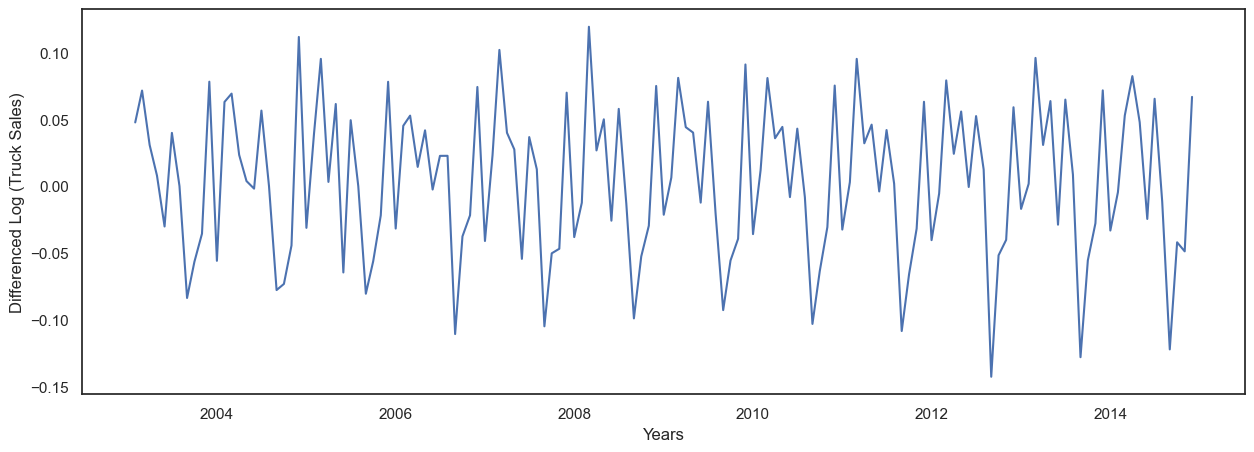

In [23]:
plt.figure(figsize=(15, 5))
plt.plot(np.log10(sales_ts).diff(periods=1))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Truck Sales)')

Text(0, 0.5, 'Differenced Log (Truck Sales)')

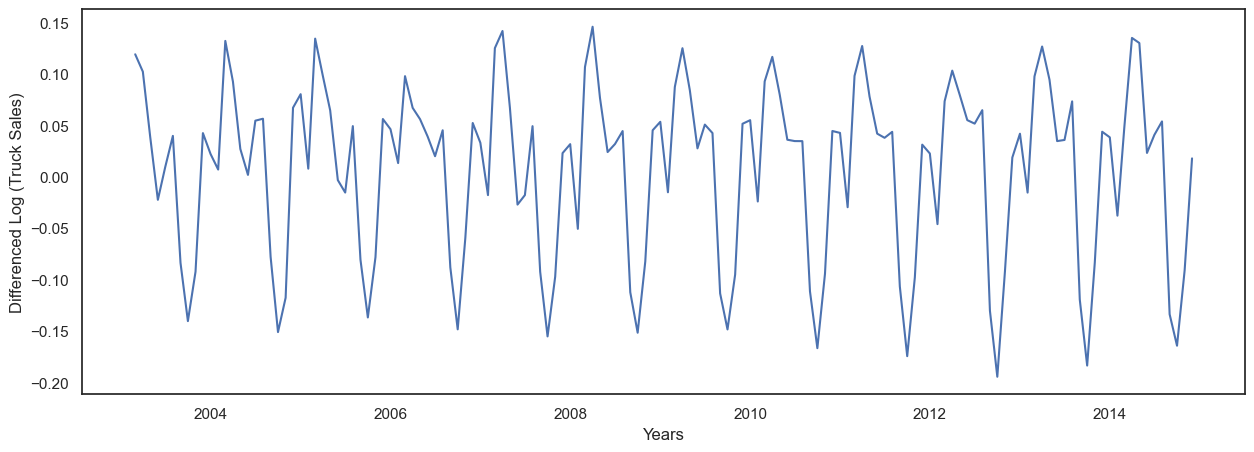

In [24]:
#trying for d=2
plt.figure(figsize=(15, 5))
plt.plot(np.log10(sales_ts).diff(periods=2))
plt.xlabel('Years')
plt.ylabel('Differenced Log (Truck Sales)')

---

<a id="2"></a>

<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>
<div style="border-radius: 50px; border: # solid; padding: 5px; background-color: #f5f9fc; font-size: 175%; text-align: Center;">
<b><span style='color:#fa762f; font-size: 18px;'> </span><span style='color:#28838a; font-size: 26px;'> Auto Regressive(AR) Models </span></b>
    </div>

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
    
- Autoregression means <b>regression of a variable on itself</b> which means <b>Autoregressive models use previous time period values to predict the current time period values.</b> <br>

- One of the fundamental assumptions of an AR model is that the <b>time series is assumed to be a stationary process.</b><br>

- An AR(p) model (Auto-Regressive model of order p) can be written as:<br>
 <font color='blue'> $y_{t}$ =   $φ_{1} y_{t-1} + φ_{2}y_{t-2} + ……+ φ_{p} y_{t-p} + ε_{t}$</font><br>

- <font color='blue'>$ε_{t}$ </font><b>is an error term which is an independent and identically distributed random variable (or in other words, a white noise) with the parameters mean = 0 and standard deviation = σ</b>
- The <font color='blue'>φ </font><b>are regression coefficients multiplied by lagged time series variable, which captures the effect of the input variable on the output, provided intermediate values do not change.</b><br>

<b><span style='color:#fa762f; font-size: 18px;'> | </span><span style='color:#28838a; font-size: 18px;'> Choose the order 'p' of AR model</span></b><br>

- We look at the Partial Autocorrelations of a stationary Time Series to understand the order of Auto-Regressive models.<br>


- For an AR model, 2 ways to identify order of 'p':<br>


<i>1) <b>PACF Approach</b> :  the PACF method where the  (Partial Auto Correlation Function) values cut off and become zero after a certain lag.               PACF vanishes if there is no regression coefficient that far back. The cut-off value where this happens can be taken as the order of AR as ‘p’. This can be seen from a PACF plot.</i><br>

- <i>If the 2nd PACF vanishes (cut off in PACF) then the 2nd coefficient is not considered and thus ‘p’ is 1.</i>
- <i>If the 3rd PACF vanishes (cuts off in PACF) then the 3rd coefficient is not considered and thus ‘p’ is 2 and so on…</i><br>



 - <b>Partial Autocorrelation of order 2 = Partial autocorrelation of lag 2 = Correlation between $𝑋_{𝑡}$ and $𝑋_{𝑡−2}$ holding $𝑋_{𝑡−1}$ fixed.</b><br>


<font color='blue'><i>2) <b>Lowest AIC Approach</b> : the lowest Akaike Information Criteria (AIC) value compared among different orders of ‘p’ is considered.</i></font>
</div>

<p style="font-size:16px; font-family:verdana; line-height: 1.7em"> <b>Using the 2nd method(Lowest AIC) to compare different orders of 'p'</b> </p> 

In [25]:
# Define the p parameter to take any value between 0 and 2
p= range(1,4)

---

<a id="3"></a>

<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>
<div style="border-radius: 50px; border: # solid; padding: 5px; background-color: #f5f9fc; font-size: 175%; text-align: Center;">
<b><span style='color:#fa762f; font-size: 18px;'> </span><span style='color:#28838a; font-size: 26px;'>  Moving Average(MA) Models </span></b>

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">    
- Moving average model <b>considers past residual values to predict the current time period values</b>
  These past residuals are past prediction errors.<br>
    

- For a MA model, <b>the residual or error component is modeled</b><br>


- The moving average model MA(q) of  order q can be represented as:<br>
 <b><font color='blue'>$y_{t} =  ε_{t} + θ_{1}ε_{t-1} +……+ θ_{q}ε_{t-q}$</font></b><br>

- <b>Where $y_{t}$  time series variable, θ are numeric coefficients multiplied to lagged residuals and ε is the residual term considered as a purely random process with mean 0, variance $σ^{2}$ and  $Cov(ε_{t-1},ε_{t-q})$ = 0.</b><br>
    
<b><span style='color:#fa762f; font-size: 18px;'> | </span><span style='color:#28838a; font-size: 18px;'> Choose the order 'q' of MA model</span></b><br>

- We look at the Autocorrelations of a stationary Time Series to understand the order of Moving Average models.<br>


- For a MA model<br>

<i>1) <b>ACF Approach</b> : ACF (Autocorrelation Function) values cut off at a certain lag. ACF vanishes, and there are no coefficients that far back; thus, the cut-off value where this happens is taken as the order of MA as ‘q’. This can be seen from the ACF plot.</i><br>



<i>2) <font color='blue'><b>Lowest AIC Approach</b> : the lowest Akaike Information Criteria (AIC) value compared among different orders of ‘q’ is considered. </i></font>
</div>

<b><span style='color:#fa762f; font-size: 18px;'>  </span><span style='color:#28838a; font-size: 20px;'> Lowest AIC Method</span></b><br>

Using the 2nd method(Lowest AIC) to compare different orders of 'q'

In [26]:
# Define the q parameter to take any value between 0 and 2
q = range(1, 4)

<div style="border-radius: 10px; border: # solid; padding: 10px; background-color: #f5f9fc; font-size: 110%; text-align: left;">
    
<b>WHY?</b><br>
- <font color='blue'>**ACF(0)=1**</font><br>
- <font color='blue'>**ACF(1)=PACF(1)**</font><br>
    
Parameter   (p, d, q) estimation matrix for estimating parameters towards building AR / ARMA / ARIMA / SARIMA models

In [27]:
d= range(0,2)

#Generate all different combinations of p with d=0 and q=0 triplets for AR model building
pdq_ar = list(itertools.product(p, range(1), range(1)))

#Generate all different combinations of p,q with d=0 triplets for ARMA model building
pdq_arma = list(itertools.product(p, range(1),q))

#Generate all different combinations of p, d and q triplets for ARIMA model building
pdq = list(itertools.product(p, d, q))

# Generate all different combinations of seasonal P,D,Q triplets for SARIMA model building
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]

In [28]:
pdq_ar

[(1, 0, 0), (2, 0, 0), (3, 0, 0)]

In [29]:
pdq_arma

[(1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3)]

In [30]:
pdq

[(1, 0, 1),
 (1, 0, 2),
 (1, 0, 3),
 (1, 1, 1),
 (1, 1, 2),
 (1, 1, 3),
 (2, 0, 1),
 (2, 0, 2),
 (2, 0, 3),
 (2, 1, 1),
 (2, 1, 2),
 (2, 1, 3),
 (3, 0, 1),
 (3, 0, 2),
 (3, 0, 3),
 (3, 1, 1),
 (3, 1, 2),
 (3, 1, 3)]

In [31]:
seasonal_pdq

[(1, 0, 1, 12),
 (1, 0, 2, 12),
 (1, 0, 3, 12),
 (1, 1, 1, 12),
 (1, 1, 2, 12),
 (1, 1, 3, 12),
 (2, 0, 1, 12),
 (2, 0, 2, 12),
 (2, 0, 3, 12),
 (2, 1, 1, 12),
 (2, 1, 2, 12),
 (2, 1, 3, 12),
 (3, 0, 1, 12),
 (3, 0, 2, 12),
 (3, 0, 3, 12),
 (3, 1, 1, 12),
 (3, 1, 2, 12),
 (3, 1, 3, 12)]

#### <u>Train test split</u>

In [32]:
#Separate data into train and test
data['date'] = data.index
train = data[data.index < '2013-01-01']
test = data[data.index >= '2013-01-01']

In [33]:
dftest = adfuller(train['Truck-Sales'])#Stationarity check on train time series data
dftest
print('DF test statistic is %3.3f' %dftest[0])
print('DF test p-value is %1.4f' %dftest[1])

DF test statistic is -0.484
DF test p-value is 0.8951


#### Using the log transformed series as there is variance in the data

In [34]:
train_sales_ts_log = np.log10(train['Truck-Sales'])
#Log transformation on the training data to make the time series stationary as we did with full data

In [35]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>
<div style="border-radius: 10px; border: # solid; padding: 10px; background-color: #f5f9fc; font-size: 110%; text-align: left;">
<b><span style='color:#fa762f; font-size: 18px;'> | </span><span style='color:#28838a; font-size: 18px;'> AR Model : Autoregressive </span></b><br>

- <b>  <font color='blue'> Use previous time period values to predict the current time period values</b></font>
    
 <u>AR Model building to estimate best 'p' ( Lowest AIC Approach )</u>
    </div>

In [36]:
# Creating an empty Dataframe with column names only
AR_AIC = pd.DataFrame(columns=['param', 'AIC'])

for param in pdq_ar:
    ARIMA_model = ARIMA(train_sales_ts_log, order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param, ARIMA_model.aic))
    row = {'param': param, 'AIC': ARIMA_model.aic}
    AR_AIC = pd.concat([AR_AIC, pd.DataFrame([row])], ignore_index=True)

ARIMA(1, 0, 0) - AIC:-345.86323814614843
ARIMA(2, 0, 0) - AIC:-346.4809804975517
ARIMA(3, 0, 0) - AIC:-344.48666318154943


#### <u>Building AR model with best <font color='blue'>'p'</font> parameter </u>

In [37]:
best_model = ARIMA(train_sales_ts_log,order = (2,0,0))#p=2 with lowest AIC
best_results = best_model.fit()

In [38]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:            Truck-Sales   No. Observations:                  120
Model:                 ARIMA(2, 0, 0)   Log Likelihood                 177.240
Date:                Wed, 22 Jan 2025   AIC                           -346.481
Time:                        17:29:30   BIC                           -335.331
Sample:                    01-01-2003   HQIC                          -341.953
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.5223      0.079     31.898      0.000       2.367       2.677
ar.L1          1.0998      0.126      8.721      0.000       0.853       1.347
ar.L2         -0.1491      0.126     -1.185      0.2

#### <u>Calculating RMSE for best AR model </u>

In [39]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)

In [40]:
pred99 = best_results.get_forecast(steps=len(test), alpha=0.1)#forecasting values

In [41]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy1 = test.copy()
testCopy1['sales_ts_forecasted'] = np.power(10, pred99.predicted_mean)

In [42]:
# Compute the root mean square error
mse = ((testCopy1['Truck-Sales'] - testCopy1['sales_ts_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 306.142


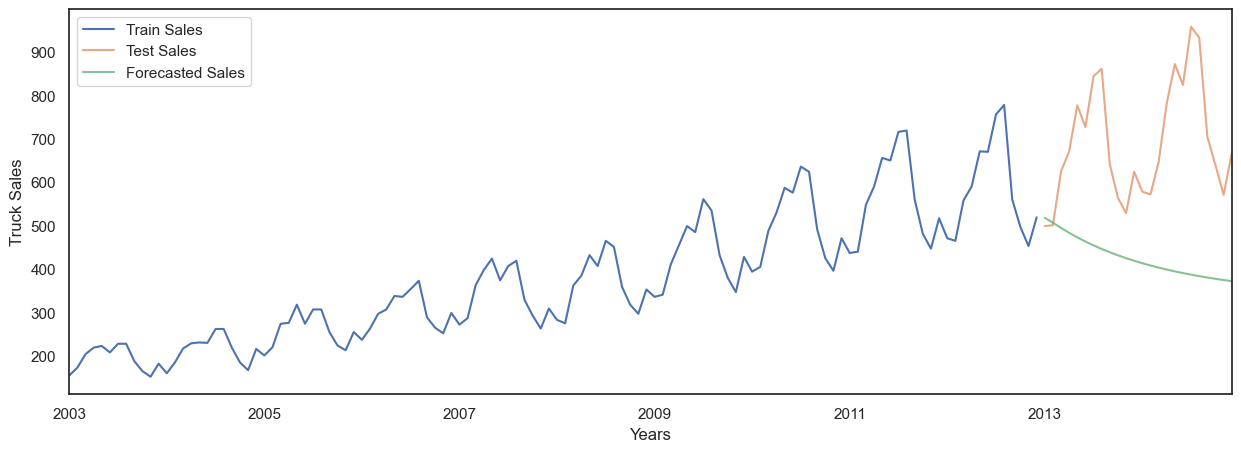

In [43]:
axis = train['Truck-Sales'].plot(label='Train Sales', figsize=(15, 5))
testCopy1['Truck-Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy1['sales_ts_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Truck Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [44]:
resultsDf = pd.DataFrame({'RMSE': rmse}
                           ,index=['Best AR Model : ARIMA(2,0,0)'])

resultsDf

,RMSE
"Best AR Model : ARIMA(2,0,0)",306.142153


---

<a id="4"></a>

<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>
<div style="border-radius: 50px; border: # solid; padding: 5px; background-color: #f5f9fc; font-size: 175%; text-align: Center;">
<b><span style='color:#fa762f; font-size: 18px;'> </span><span style='color:#28838a; font-size: 26px;'>  ARMA Model </span></b>

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">    
    - <b>Improving AutoRegressive Models through Moving Average Forecasts.</b><br>
- ARMA models consist of 2 components:-<br>
	- AR model: <font color='blue'>The data is modeled based on past observations.</font><br>
	- MA model: <font color='blue'>Previous forecast errors are incorporated into the model.</font>
    </div>

#### <u>ARMA Model building to estimate best <font color='blue'>'p' , 'q' </font> ( Lowest AIC Approach )</u>

In [45]:
# Creating an empty Dataframe with column names only
ARMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARMA_AIC

,param,AIC


In [46]:
for param in pdq_arma:
    ARIMA_model = ARIMA(train_sales_ts_log,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param, ARIMA_model.aic))
    row = {'param': param, 'AIC': ARIMA_model.aic}
    ARMA_AIC = pd.concat([ARMA_AIC, pd.DataFrame([row])], ignore_index=True)

ARIMA(1, 0, 1) - AIC:-346.4412586465578
ARIMA(1, 0, 2) - AIC:-344.4999386905492
ARIMA(1, 0, 3) - AIC:-354.4420520619334
ARIMA(2, 0, 1) - AIC:-344.4854973044397
ARIMA(2, 0, 2) - AIC:-347.2827213671626
ARIMA(2, 0, 3) - AIC:-352.55104214176237
ARIMA(3, 0, 1) - AIC:-346.9136747559918
ARIMA(3, 0, 2) - AIC:-345.3210947444512
ARIMA(3, 0, 3) - AIC:-383.9325296326567


In [47]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
8,"(3, 0, 3)",-383.932530
2,"(1, 0, 3)",-354.442052
5,"(2, 0, 3)",-352.551042
4,"(2, 0, 2)",-347.282721
6,"(3, 0, 1)",-346.913675


#### <u>Building ARMA model with best p,q parameter </u>

In [48]:
best_model = ARIMA(train_sales_ts_log,order = (3,0,3))
best_results = best_model.fit()

In [49]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:            Truck-Sales   No. Observations:                  120
Model:                 ARIMA(3, 0, 3)   Log Likelihood                 199.966
Date:                Wed, 22 Jan 2025   AIC                           -383.933
Time:                        17:29:33   BIC                           -361.633
Sample:                    01-01-2003   HQIC                          -374.876
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4969      1.247      2.002      0.045       0.053       4.941
ar.L1         -0.7110      0.029    -24.720      0.000      -0.767      -0.655
ar.L2          0.7145      0.031     22.685      0.0

#### <u>Calculating RMSE for best MA model </u>

In [50]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)

In [51]:
pred99 = best_results.get_forecast(steps=len(test), alpha=0.1)#forecasting values

In [52]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy1 = test.copy()
testCopy1['sales_ts_forecasted'] = np.power(10, pred99.predicted_mean)

In [53]:
sales_ts_forecasted

2012-01-01    2.715211
2012-02-01    2.708732
2012-03-01    2.727658
2012-04-01    2.697395
2012-05-01    2.726107
2012-06-01    2.702555
2012-07-01    2.710258
2012-08-01    2.715997
2012-09-01    2.694416
2012-10-01    2.721384
2012-11-01    2.692395
2012-12-01    2.711198
Freq: MS, Name: predicted_mean, dtype: float64

In [54]:
# Compute the root mean square error
mse = ((testCopy1['Truck-Sales'] - testCopy1['sales_ts_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 225.536


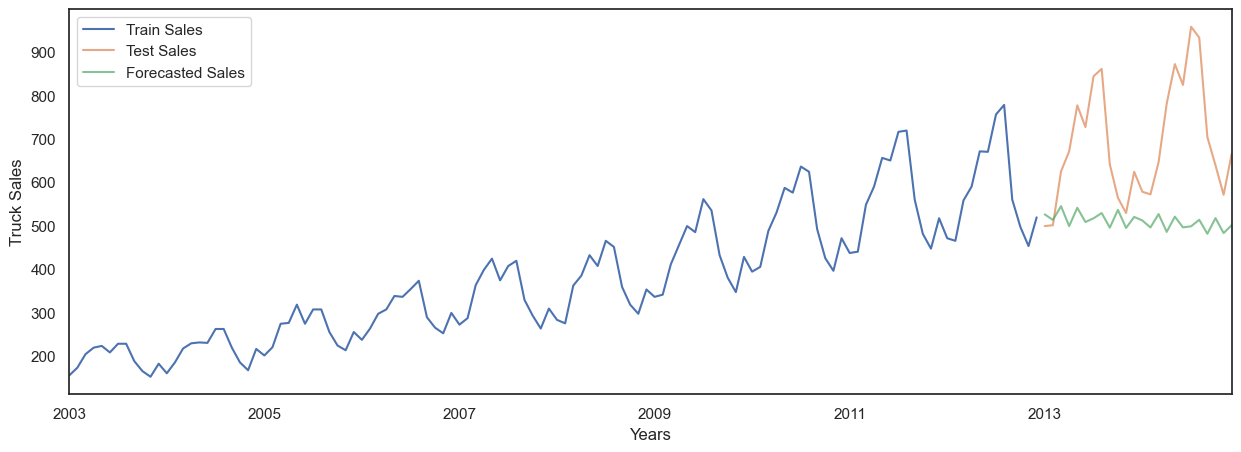

In [55]:
axis = train['Truck-Sales'].plot(label='Train Sales', figsize=(15, 5))
testCopy1['Truck-Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy1['sales_ts_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Truck Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [56]:
resultsDf1 = pd.DataFrame({'RMSE': rmse}
                           ,index=['Best ARMA Model : ARIMA(3,0,3)'])

resultsDf1

pd.concat([resultsDf,resultsDf1])

,RMSE
"Best AR Model : ARIMA(2,0,0)",306.142153
"Best ARMA Model : ARIMA(3,0,3)",225.536383



---

<a id="5"></a>

<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>
<div style="border-radius:10px; border: # solid; padding: 5px; background-color: #f5f9fc; font-size: 175%; text-align: Center;">
<b><span style='color:#fa762f; font-size: 18px;'> </span><span style='color:#28838a; font-size: 26px;'>  ARIMA Model </span></b>

<center><img src='https://www.researchgate.net/publication/350642995/figure/fig1/AS:1019618659418115@1620107440541/The-relationship-between-ARMA-and-ARIMA.png' 
     height=100px width=500px /></center>     


<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
    
- ARIMA:- <b>Auto Regressive Integrated Moving Average</b> is a way of modeling time series data <b>for forecasting or predicting future data points</b>.<br>
- <b>Improving AR Models by making Time Series stationary through Moving AVerage Forecasts</b><br>


- ARIMA models consist of 3 components:-<br>
	- <b>AR model: <font color='blue'>The data is modeled based on past observations.</font></b><br>
	- <b>Integrated component: <font color='blue'>Whether the data needs to be differenced/transformed.</font></b><br>
    - <b>MA model: <font color='blue'>Previous forecast errors are incorporated into the model.</font></b>
    
    </div>

#### <u>ARIMA Model building to estimate best <font color='blue'>'p' , 'd' , 'q' </font> paramters ( Lowest AIC Approach )</u>

In [57]:
# Creating an empty Dataframe with column names only
ARIMA_AIC = pd.DataFrame(columns=['param', 'AIC'])
ARIMA_AIC

,param,AIC


In [58]:
for param in pdq:
    ARIMA_model = ARIMA(train_sales_ts_log,order=param).fit()
    print('ARIMA{} - AIC:{}'.format(param, ARIMA_model.aic))
    row = {'param': param, 'AIC': ARIMA_model.aic}
    ARIMA_AIC = pd.concat([ARIMA_AIC, pd.DataFrame([row])], ignore_index=True)

ARIMA(1, 0, 1) - AIC:-346.4412586465578
ARIMA(1, 0, 2) - AIC:-344.4999386905492
ARIMA(1, 0, 3) - AIC:-354.4420520619334
ARIMA(1, 1, 1) - AIC:-345.29068676461014
ARIMA(1, 1, 2) - AIC:-343.30244747011585
ARIMA(1, 1, 3) - AIC:-357.3492792157578
ARIMA(2, 0, 1) - AIC:-344.4854973044397
ARIMA(2, 0, 2) - AIC:-347.2827213671626
ARIMA(2, 0, 3) - AIC:-352.55104214176237
ARIMA(2, 1, 1) - AIC:-353.37064650474326
ARIMA(2, 1, 2) - AIC:-372.5758546584856
ARIMA(2, 1, 3) - AIC:-355.411392594088
ARIMA(3, 0, 1) - AIC:-346.9136747559918
ARIMA(3, 0, 2) - AIC:-345.3210947444512
ARIMA(3, 0, 3) - AIC:-383.9325296326567
ARIMA(3, 1, 1) - AIC:-354.4194537309886
ARIMA(3, 1, 2) - AIC:-355.31564759594215
ARIMA(3, 1, 3) - AIC:-372.6978618406828


In [59]:
## Sort the above AIC values in the ascending order to get the parameters for the minimum AIC value

ARIMA_AIC.sort_values(by='AIC',ascending=True).head()

,param,AIC
14,"(3, 0, 3)",-383.932530
17,"(3, 1, 3)",-372.697862
10,"(2, 1, 2)",-372.575855
5,"(1, 1, 3)",-357.349279
11,"(2, 1, 3)",-355.411393


#### <u>Building ARIMA model with best parameters p,d,q</u>

In [60]:
best_model = ARIMA(train_sales_ts_log,order = (3,1,3))
best_results = best_model.fit()

In [61]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                               SARIMAX Results                                
Dep. Variable:            Truck-Sales   No. Observations:                  120
Model:                 ARIMA(3, 1, 3)   Log Likelihood                 193.349
Date:                Wed, 22 Jan 2025   AIC                           -372.698
Time:                        17:29:38   BIC                           -353.244
Sample:                    01-01-2003   HQIC                          -364.798
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7642      0.175      4.366      0.000       0.421       1.107
ar.L2         -0.8216      0.072    -11.426      0.000      -0.963      -0.681
ar.L3          0.6954      0.146      4.757      0.0

#### <u>Calculating RMSE for best ARIMA model </u>

In [62]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)

In [63]:
pred99 = best_results.get_forecast(steps=len(test), alpha=0.1)#forecasting values

In [64]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy1 = test.copy()
testCopy1['sales_ts_forecasted'] = np.power(10, pred99.predicted_mean)

In [65]:
# Compute the root mean square error
mse = ((testCopy1['Truck-Sales'] - testCopy1['sales_ts_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)

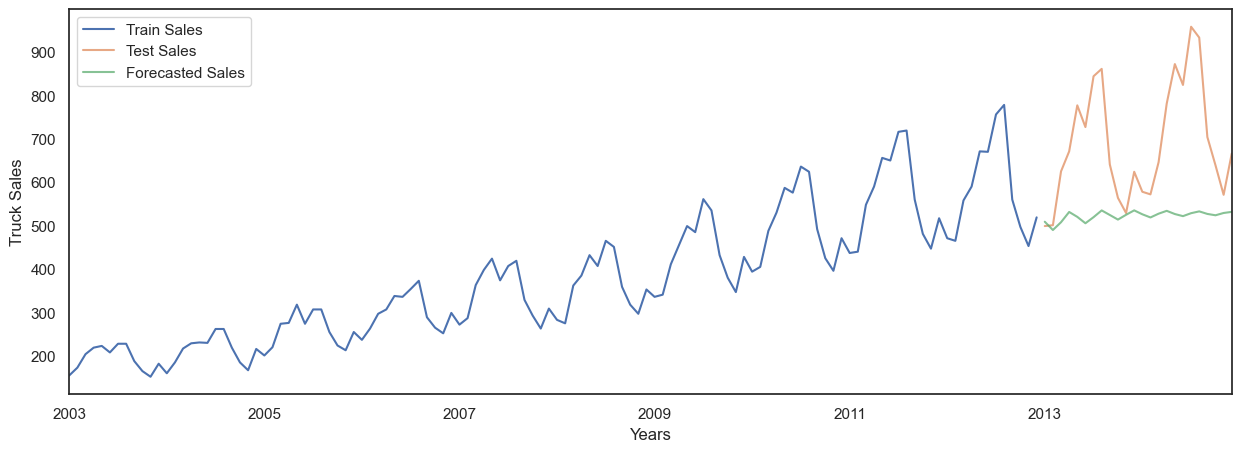

In [66]:
axis = train['Truck-Sales'].plot(label='Train Sales', figsize=(15, 5))
testCopy1['Truck-Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy1['sales_ts_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Truck Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [67]:
resultsDf2 = pd.DataFrame({'RMSE': rmse}
                           ,index=['Best ARIMA Model : ARIMA(3,0,3)'])

resultsDf2

pd.concat([resultsDf,resultsDf1,resultsDf2])

,RMSE
"Best AR Model : ARIMA(2,0,0)",306.142153
"Best ARMA Model : ARIMA(3,0,3)",225.536383
"Best ARIMA Model : ARIMA(3,0,3)",212.511131


<a id="6"></a>

<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>
<div style="border-radius: 50px; border: # solid; padding: 5px; background-color: #f5f9fc; font-size: 175%; text-align: Center;">
<b><span style='color:#fa762f; font-size: 18px;'> </span><span style='color:#28838a; font-size: 26px;'>  SARIMA Model </span></b>

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
    
- <b>The ARIMA models can be extended/improved to handle seasonal components of a data series</b><br>

- The seasonal autoregressive moving average model is given by<br>
<center><img src='https://miro.medium.com/v2/resize:fit:1400/1*yxe5Sf5JSAROq-UVgMLtmA.png' width=500px height=100px/></center>

- The above model consists of:<br>
	- <font color='blue'>Autoregressive and moving average components (p, q)</font><br>
	- <font color='blue'>Seasonal autoregressive and moving average components (P, Q) </font><br>
	- <font color='blue'>The ordinary and seasonal difference components of order ‘d’ and ‘D’ </font><br>
	- <font color='blue'>Seasonal frequency ‘F’</font><br>
    

- The value for the parameters (p,d,q) and (P, D, Q) can be decided by comparing different values for each and taking <b>the lowest   AIC value</b> for the model build.<br>


- <b>The value for F can be consolidated by ACF plot</b>

</div>

#### <u>Finding Seasonality = 12 from ACF/PACF plots </u>

<Figure size 1500x400 with 0 Axes>

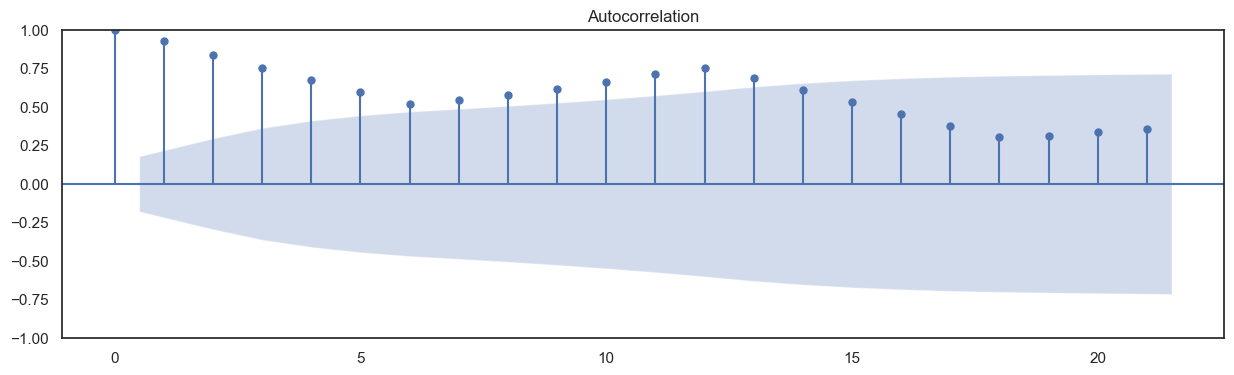

In [68]:
plt.figure(figsize=(15, 4))
plot_acf(train['Truck-Sales'],alpha=0.05);

#### <u>SARIMA Model building to estimate best parameters </u>

In [69]:
best_aic = np.inf
best_pdq = None
best_seasonal_pdq = None
temp_model = None

In [70]:
SARIMA_AIC = pd.DataFrame(columns=['param','seasonal', 'AIC'])
SARIMA_AIC

,param,seasonal,AIC


In [71]:
SARIMA_AIC = pd.DataFrame(columns=['param', 'seasonal', 'AIC'])

for param in pdq:
    for param_seasonal in seasonal_pdq:
        SARIMA_model = sm.tsa.statespace.SARIMAX(train_sales_ts_log,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=False,
                                            enforce_invertibility=False)

results_SARIMA = SARIMA_model.fit(maxiter=1000)
print('SARIMA{}x{} - AIC:{}'.format(param, param_seasonal, results_SARIMA.aic))
SARIMA_AIC.loc[len(SARIMA_AIC)] = [param, param_seasonal, results_SARIMA.aic]

SARIMA(3, 1, 3)x(3, 1, 3, 12) - AIC:-385.08625052845116


In [72]:
SARIMA_AIC.sort_values(by=['AIC'],ascending=True).head()


,param,seasonal,AIC
0,"(3, 1, 3)","(3, 1, 3, 12)",-385.086251


<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;"><b><span style='color:#fa762f; font-size: 18px;'> </span><span style='color:#28838a; font-size: 18px;'> Inference</span></b>

* Criteria to choose the best fit model is the lowest/minimum AIC value<br>

For ARIMA(p, d, q) × (P, D, Q)S,<br>
we got SARIMAX(1, 0, 1)x(1, 0, 1, 12)model with the least AIC of -559.278050<br>

Here,<br>
- p = non-seasonal AR order = 1,<br>
- d = non-seasonal differencing = 0,<br>
- q = non-seasonal MA order = 1,<br>
- P = seasonal AR order = 1,<br>
- D = seasonal differencing = 0,<br>
- Q = seasonal MA order = 1,<br>
- S = time span of repeating seasonal pattern = 12<br>

<u>Building SARIMA model with the best parameters </u>
</div>

In [73]:
best_model = sm.tsa.statespace.SARIMAX(train_sales_ts_log,
                                      order=(1, 0, 1),
                                      seasonal_order=(1, 0, 1, 12),
                                      enforce_stationarity=True)
best_results = best_model.fit()

In [74]:
print(best_results.summary().tables[0])
print(best_results.summary().tables[1])

                                     SARIMAX Results                                      
Dep. Variable:                        Truck-Sales   No. Observations:                  120
Model:             SARIMAX(1, 0, 1)x(1, 0, 1, 12)   Log Likelihood                 302.280
Date:                            Wed, 22 Jan 2025   AIC                           -594.560
Time:                                    17:29:59   BIC                           -580.622
Sample:                                01-01-2003   HQIC                          -588.900
                                     - 12-01-2012                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9956      0.006    159.267      0.000       0.983       1.008
ma.L1         -0.2952      0.084   

In [75]:
pred_dynamic = best_results.get_prediction(start=pd.to_datetime('2012-01-01'), dynamic=True, full_results=True)

In [76]:
pred99 = best_results.get_forecast(steps=len(test), alpha=0.1)

In [77]:
# Extract the predicted and true values of our time series
sales_ts_forecasted = pred_dynamic.predicted_mean
testCopy = test.copy()
testCopy['sales_ts_forecasted'] = np.power(10, pred99.predicted_mean)

In [78]:
testCopy

,Month,Year,Truck-Sales,date,sales_ts_forecasted
2013-01-01,Jan,2013,499,2013-01-01,481.766340
2013-02-01,Feb,2013,501,2013-02-01,482.510075
2013-03-01,Mar,2013,625,2013-03-01,584.533196
2013-04-01,Apr,2013,671,2013-04-01,623.915807
2013-05-01,May,2013,777,2013-05-01,697.312688
2013-06-01,Jun,2013,727,2013-06-01,687.599498
2013-07-01,Jul,2013,844,2013-07-01,767.222264
2013-08-01,Aug,2013,861,2013-08-01,773.016831
2013-09-01,Sep,2013,641,2013-09-01,585.779745
2013-10-01,Oct,2013,564,2013-10-01,514.216305


In [79]:
# Compute the root mean square error
mse = ((testCopy['Truck-Sales'] - testCopy['sales_ts_forecasted']) ** 2).mean()
rmse = np.sqrt(mse)
print('The Root Mean Squared Error of our forecasts is {}'.format(round(rmse, 3)))

The Root Mean Squared Error of our forecasts is 84.254


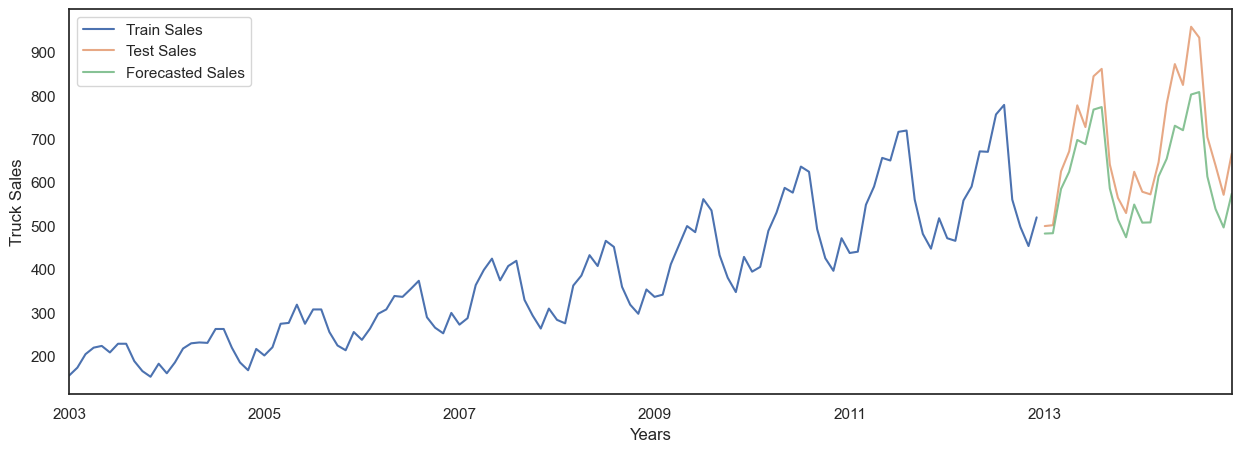

In [80]:
axis = train['Truck-Sales'].plot(label='Train Sales', figsize=(15, 5))
testCopy['Truck-Sales'].plot(ax=axis, label='Test Sales', alpha=0.7)
testCopy['sales_ts_forecasted'].plot(ax=axis, label='Forecasted Sales', alpha=0.7)
axis.set_xlabel('Years')
axis.set_ylabel('Truck Sales')
plt.legend(loc='best')
plt.show()
plt.close()

In [81]:
resultsDf3 = pd.DataFrame({'RMSE': rmse}
                           ,index=['Best SARIMA Model : SARIMAX(1, 0, 1)x(1, 0, 1, 12)'])

pd.concat([resultsDf,resultsDf1,resultsDf2,resultsDf3])

,RMSE
"Best AR Model : ARIMA(2,0,0)",306.142153
"Best ARMA Model : ARIMA(3,0,3)",225.536383
"Best ARIMA Model : ARIMA(3,0,3)",212.511131
"Best SARIMA Model : SARIMAX(1, 0, 1)x(1, 0, 1, 12)",84.253701


<a id="toc"></a>

<a href="#toc" style="background-color: #28838a; color: #ffffff; padding: 7px 10px; text-decoration: none; border-radius: 50px;"></a>

<a id="7"></a>

<div style="border-radius: 50px; border: # solid; padding: 5px; background-color: #f5f9fc; font-size: 175%; text-align: Center;">
<b><span style='color:#fa762f; font-size: 18px;'> </span><span style='color:#28838a; font-size: 26px;'> Forecast sales using the best fit SARIMA model as per RMSE </span></b>

In [82]:
# Get forecast 36 steps (3 years) ahead in future
n_steps = 60
pred_uc_99 = best_results.get_forecast(steps=60, alpha=0.01) # alpha=0.01 signifies 99% confidence interval
pred_uc_95 = best_results.get_forecast(steps=60, alpha=0.05) # alpha=0.05 95% CI

# Get confidence intervals 95% & 99% of the forecasts
pred_ci_99 = pred_uc_99.conf_int()
pred_ci_95 = pred_uc_95.conf_int()

In [83]:
n_steps = 60
idx = pd.date_range(start='2015-01-01',end='2019-12-31',freq='MS')
fc_95 = pd.DataFrame(np.column_stack([np.power(10, pred_uc_95.predicted_mean), np.power(10, pred_ci_95)]),
                     index=idx, columns=['forecast', 'lower_ci_95', 'upper_ci_95'])
fc_99 = pd.DataFrame(np.column_stack([np.power(10, pred_ci_99)]),
                     index=idx, columns=['lower_ci_99', 'upper_ci_99'])
fc_all = fc_95.combine_first(fc_99)
fc_all = fc_all[['forecast', 'lower_ci_95', 'upper_ci_95', 'lower_ci_99', 'upper_ci_99']] # just reordering columns
fc_all.head()

,forecast,lower_ci_95,upper_ci_95,lower_ci_99,upper_ci_99
2015-01-01,481.766340,447.703473,518.420831,447.703473,518.420831
2015-02-01,482.510075,441.189392,527.700748,441.189392,527.700748
2015-03-01,584.533196,527.268614,648.017061,527.268614,648.017061
2015-04-01,623.915807,556.143168,699.947346,556.143168,699.947346
2015-05-01,697.312688,614.965721,790.686324,614.965721,790.686324


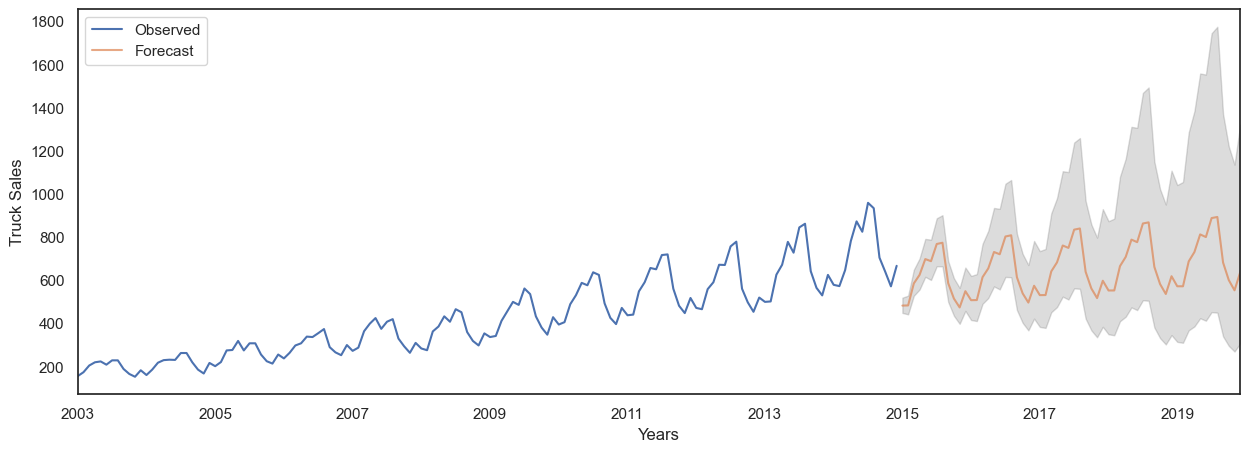

In [84]:
# plot the forecast along with the confidence band

axis = sales_ts.plot(label='Observed', figsize=(15, 5))
fc_all['forecast'].plot(ax=axis, label='Forecast', alpha=0.7)
axis.fill_between(fc_all.index, fc_all['lower_ci_95'], fc_all['upper_ci_95'], color='k', alpha=.15)
axis.set_xlabel('Years')
axis.set_ylabel('Truck Sales')
plt.legend(loc='best')
plt.show()

<b><u>Plot ACF and PACF for residuals of ARIMA model to ensure no more information is left for extraction</u></b>

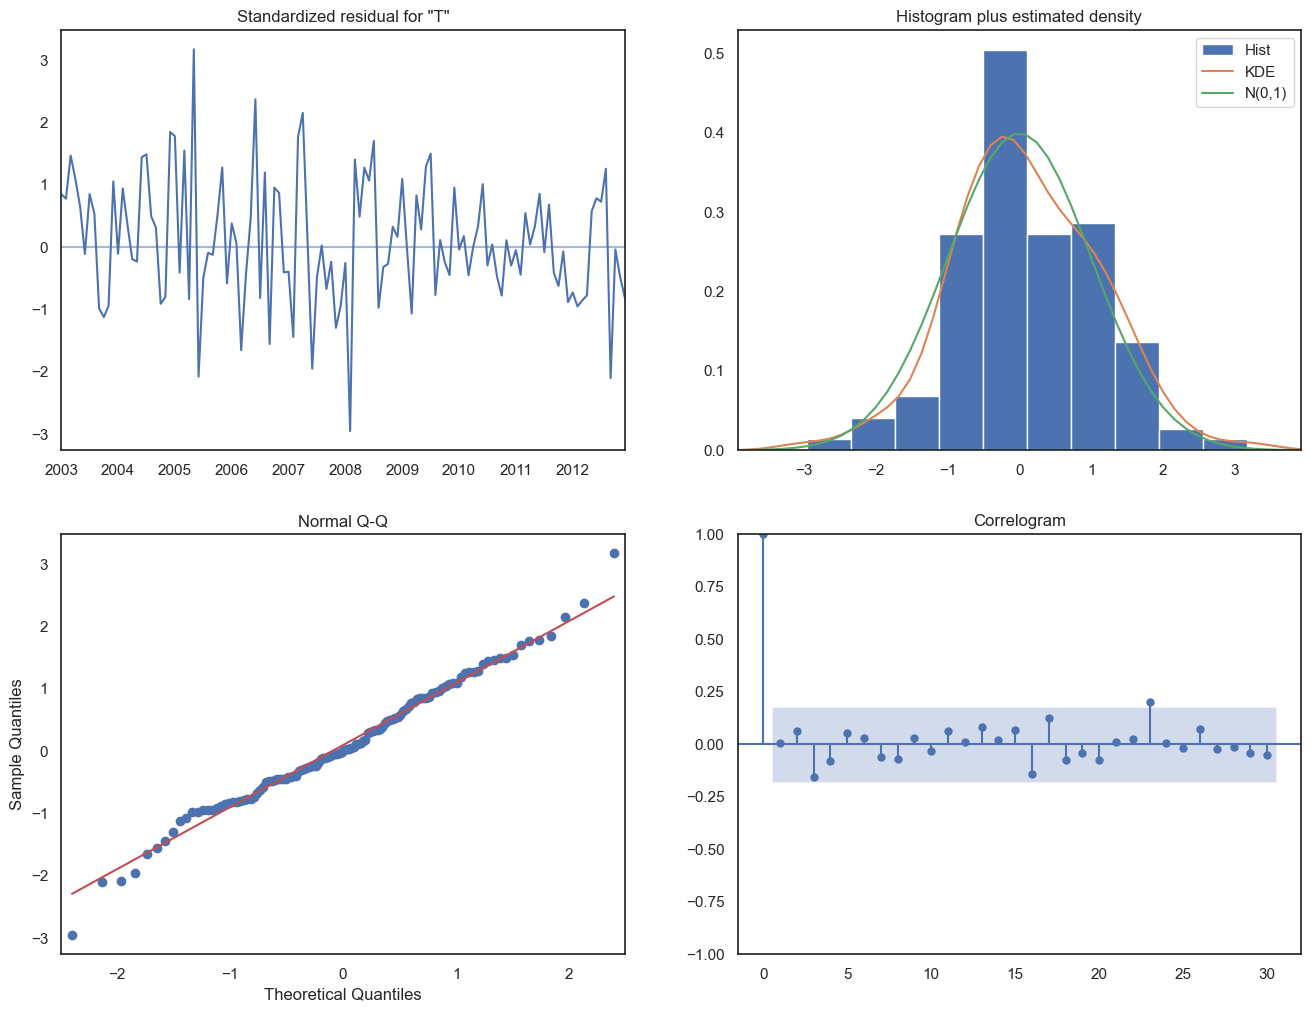

In [85]:
best_results.plot_diagnostics(lags=30, figsize=(16,12))
plt.show()

<a id="8"></a>

<div style="background-color:#f0f4f5; padding: 5px;">
<div class="alert alert-block alert-secondary" style="font-size:18px; font-family:verdana;">
    
<b><span style='color:#28838a; font-size: 20px;'> Inference</span></b><br>
    
Note : <u>4 plots in the residuals diagnostic plots tell us</u> :<br>

- <b>Standardized residuals plot</b> <i>The top left plot shows 1-step-ahead standardized residuals.<br>
    If model is working correctly, then no pattern should be obvious in the residuals which is clearly not visible from the plot as well .</i><br><br>



- <b>Histogram plus estimated density plot</b> <i>This plot shows the distribution of the residuals.The orange line shows a smoothed version of this histogram, and the green line shows a normal distribution. If the model is good these two lines should be the same. Here there are small differences between them, which indicate that our model is doing just well enough.</i><br><br>



- <b>Normal Q-Q plot</b> <i>The Q-Q plot compare the distribution of residuals to normal distribution. If the distribution of the residuals is normal, then all the points should lie along the red line, except for some values at the end, which is exactly happening in this case.</i><br><br>



- <b>Correlogram plot</b> <i>The correlogram plot is the ACF plot of the residuals rather than the data. 95% of the correlations for lag >0  should not be significant (within the blue shades). If there is a significant correlation in the residuals, it means that there is information in the data that was not captured by the model, which is clearly not in this case</i>.<br>
    
    </div>

 <center><img src='https://www.researchgate.net/publication/343666568/figure/fig1/AS:992610042777600@1613668084242/The-Box-Jenkins-methodology-and-its-steps-ARIMA.ppm' width=900px height=10px  /></center>